# Getting Started with the Arize Platform - Investigating Performance Dip

Let's get started on using Arize! ✨

Arize helps you visualize your model performance, understand drift & data quality issues, and share insights learned from your models.

### What this walkthrough will cover:

#### **Background** 

In this walkthrough, we are going to be looking at the Lending Club dataset. Lending Club is a peer to peer lending company based in the United States. We would like to use this data to predict whether a loan will be a *good* loan or a *bad* loan. Specifically, a *bad* loan is one that defaults, one that does not meet the credit policy, is late, or has other troublesome factors.

#### **Model**

In this walkthrough, we will skip creating the actual model, and instead load in some preexisting data. We have built out a classifier to model the loan condition and will import the training data, test data, and predictions. Using a preexisting model saves time in this example, but also illustrates how simple it is to plug into the Arize platform.

#### **Troubleshooting the Model**

We will then demonstrate how Arize allows you to troubleshoot and monitor the model. In this example, we will investigate a dip in performance and how you could easily track down the root cause as data drift of a single feature.

#### **Monitoring**

After identifying the source of the performance dip as feature drift, we will set up a monitor to alert us when the feature drifts in the future. This way we can stay on top of drift and ensure our model is always performing.


# Setup and Getting the Data 

###Install Dependencies and Import Libraries 📚

In [ ]:
!pip install arize -q
!pip install tables --upgrade -q

print("✅ Dependencies Installed!")

     |████████████████████████████████| 1.3MB 6.9MB/s 
ERROR: tensorflow-metadata 0.29.0 has requirement googleapis-common-protos<2,>=1.52.0, but you'll have googleapis-common-protos 1.51.0 which is incompatible.
     |████████████████████████████████| 4.3MB 5.1MB/s 


In [ ]:
import pandas as pd
import requests
import io
from arize.types import ModelTypes

print("✅ Libraries Imported!")

### Download the Data 🌐
For our model we have **3 Environments**: training, validation, and production. We download each of them, storing them in a dictionary `datasets` for later use.

In [ ]:
environments = ['training', 'validation', 'production']
datasets = {}

for environment in environments:
  
  url = 'https://storage.googleapis.com/arize-assets/fixtures/value_showcase_' + environment + '_data.h5'
  r = requests.get(url)
  with open('value_showcase_' + environment + '_data.h5', 'wb') as f:
      f.write(r.content)

  # Create the dataframe and store in dictionary
  datasets[environment] = pd.read_hdf('value_showcase_' + environment + '_data.h5')

print("✅ Data successfully downloaded!")

We also download the SHAP data separately, storing it in the  `lending_data_shap_df` dataframe.

In [ ]:
# Download the SHAP data to a local file
url = 'https://storage.googleapis.com/arize-assets/fixtures/value_showcase_production_shap.h5'
r = requests.get(url)
with open('value_showcase_production_data_shap.h5', 'wb') as f:
    f.write(r.content)

# Create the SHAP dataframe
lending_data_shap_df = pd.read_hdf("value_showcase_production_data_shap.h5")

print("✅ SHAP data successfully downloaded!")

Of the data we downloaded, these are the columns that correspond to the features of the model.

In [ ]:
features = ['loan_amount',	'term',	'interest_rate',	'installment',	'grade',	'home_ownership',	'annual_income',	'verification_status',	'pymnt_plan',	'purpose',	'addr_state',	'dti',	'delinq_2yrs',	'inq_last_6mths',	'mths_since_last_delinq',	'mths_since_last_record',	'open_acc',	'pub_rec',	'revol_bal',	'revol_util',	'total_acc',	'actuals',	'predictions',	'fico_score',	'fico_range']

print("✅ Done!")

# Sending Data into Arize 💫

Now that we have our data configured, we are ready to integrate into Arize 

For our model, we are going to log:


*   feature data
*   predictions
*   actuals
*   SHAP values for explainability metrics

The first step is to setup our Arize client. After that we will log the data.





## Import and Setup Arize Client

You can find your `API_KEY` and `ORGANIZATION_KEY` at on your [Settings Page](https://app.arize.com/admin). Copy those over to the set-up section. We will also be setting up some metadata to use across all logging.
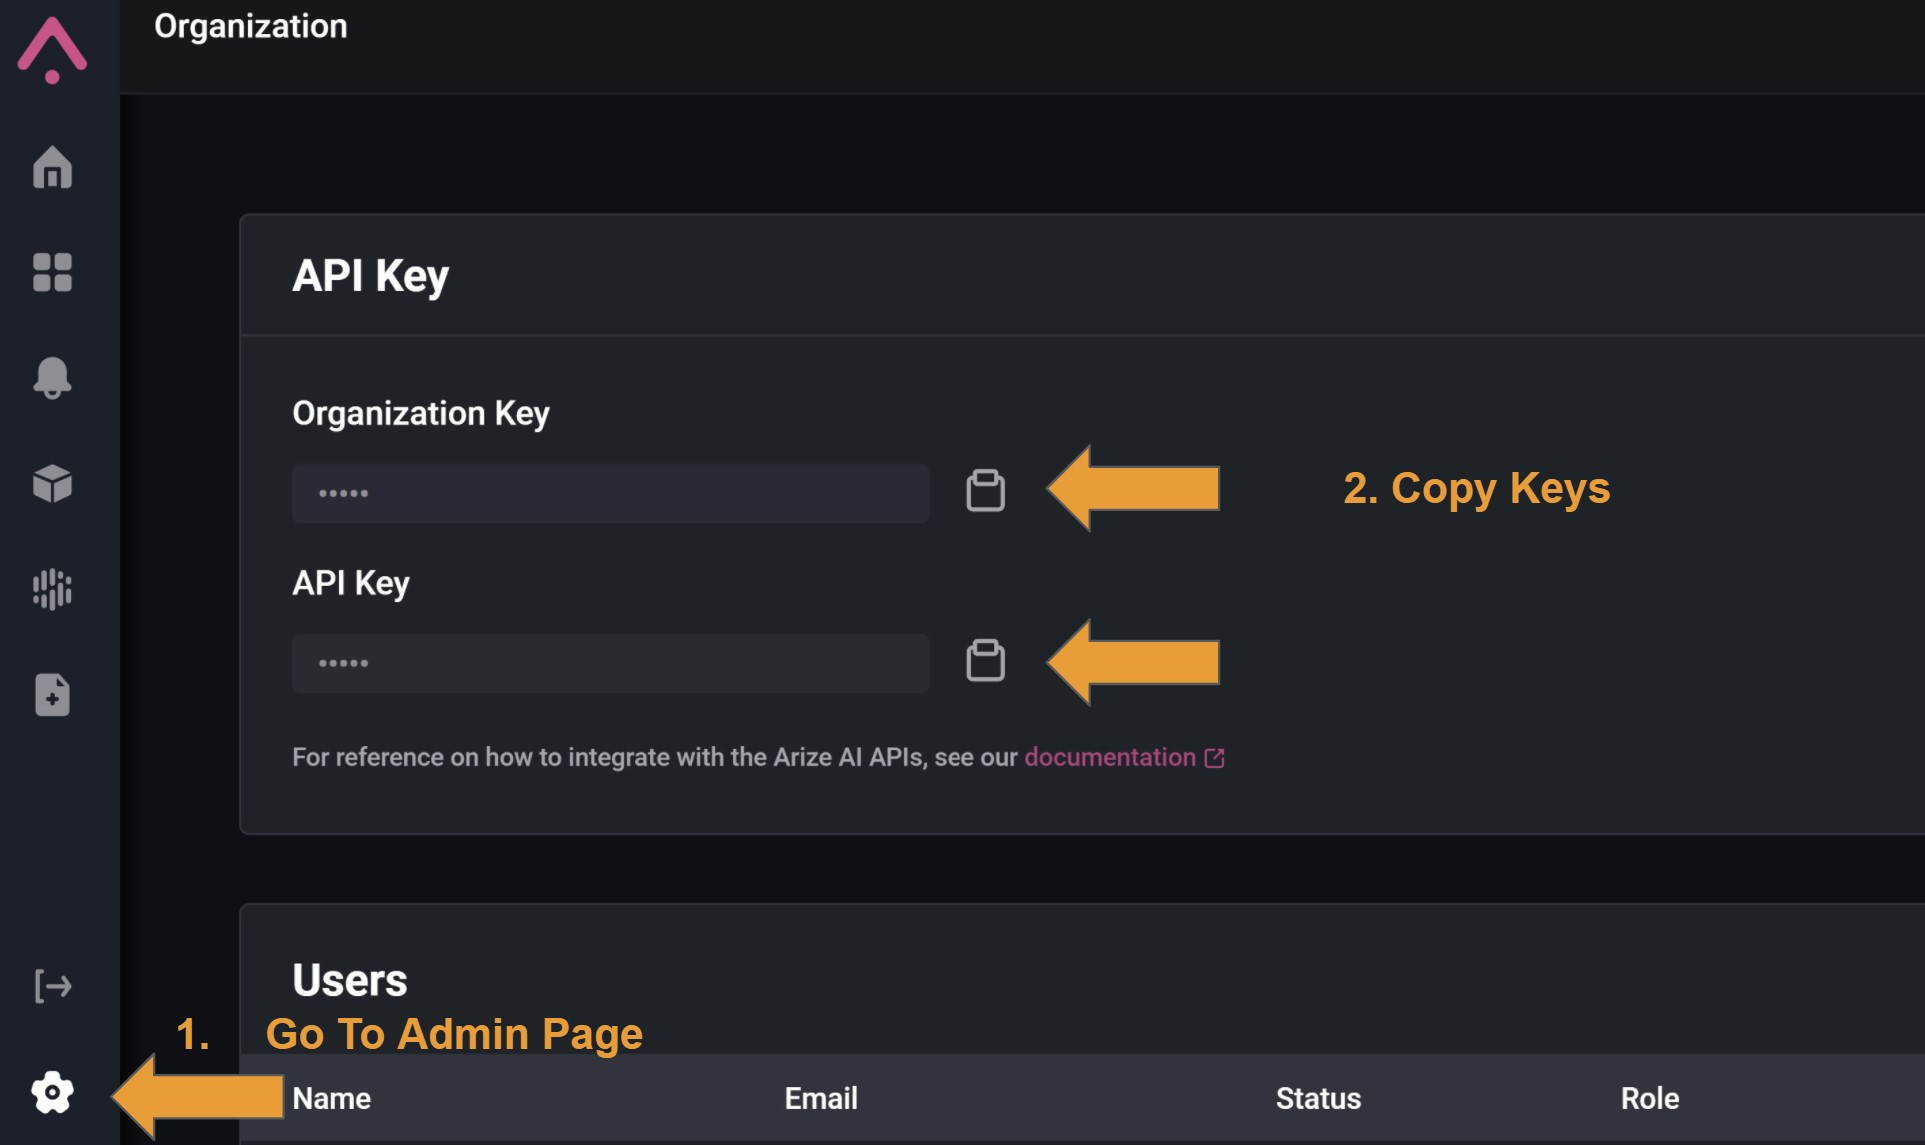

In [ ]:
from arize.api import Client
from arize.types import ModelTypes

ORGANIZATION_KEY = 'ORGANIZATION_KEY'
API_KEY = 'API_KEY'
arize = Client(organization_key=ORGANIZATION_KEY, api_key=API_KEY)

model_id = 'lending-club-performance-dip-tutorial' # This is the model name that will show up in Arize
model_version = 'v1.0' # Version of model - can be any string

## Log the Prediction Data
Now that our Arize client is setup, let's go ahead and log all of our data to the platform.

### Log Training Data onto Arize

In [ ]:
training_dataset = datasets['training']

responses = arize.log_training_records(
    model_id=model_id + "-" + model_version,
    model_version=model_version,
    model_type=ModelTypes.SCORE_CATEGORICAL,
    prediction_labels=training_dataset['predictions'],
    prediction_scores=training_dataset['predictions_score'],
    actual_labels=training_dataset['actuals'],
    features=training_dataset[features],
    )

### Log Validation Data onto Arize

In [ ]:
validation_dataset = datasets['validation']

responses = arize.log_validation_records(
    batch_id = str(1),
    model_id=model_id + "-" + model_version,
    model_version=model_version,
    model_type=ModelTypes.SCORE_CATEGORICAL,
    prediction_labels=validation_dataset['predictions'],
    prediction_scores=validation_dataset['predictions_score'],
    actual_labels=validation_dataset['actuals'],
    features=validation_dataset[features],
    )

### Log Production Data onto Arize

In [ ]:
production_dataset = datasets['production']

log_bulk_responses = arize.bulk_log(
    model_id=model_id + "-" + model_version,
    model_version=model_version,
    model_type=ModelTypes.SCORE_CATEGORICAL,
    prediction_ids=production_dataset['prediction_ids'],
    prediction_labels=production_dataset['predictions'],
    actual_labels=production_dataset['actuals'],
    prediction_timestamps=production_dataset['model_date'].apply(lambda t: int(t.timestamp())),
    shap_values=lending_data_shap_df,
    features=production_dataset[features]
)

### Coffee Time! ☕️
Note that because of the indexing Arize performs on data load, there's a delay before data appears on the platform. While the model should appear immediately, the data may take up to 10 minutes to show up. Feel free to go grab a cup of coffee as Arize works its magic! 🔮

**⚠️ Important:** 
In order to move on to the next step, make sure your actuals and training/validation sets are loaded into the platform. To check this, go to the **Datasets** tab and make sure you see in the *Environment* column one for *Training* and *Validation* as shown below.

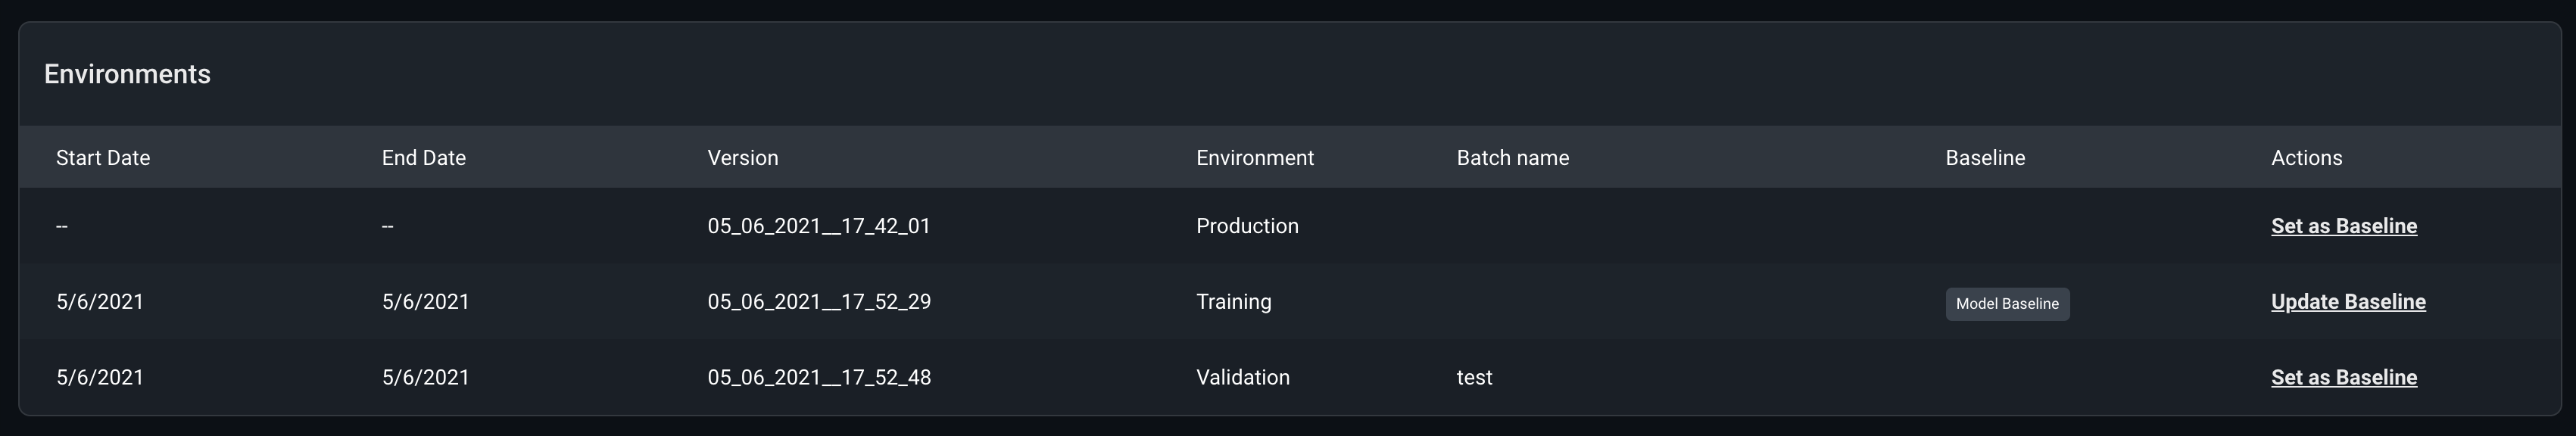

# Explore the Platform  🔎

Welcome back! Now we can go take a look at the [Arize platform](https://app.arize.com/) and take a look at the logged data. Head over to the **Models** page and select our newly created model `lending-club-tutorial`. The overview page should look like this: 

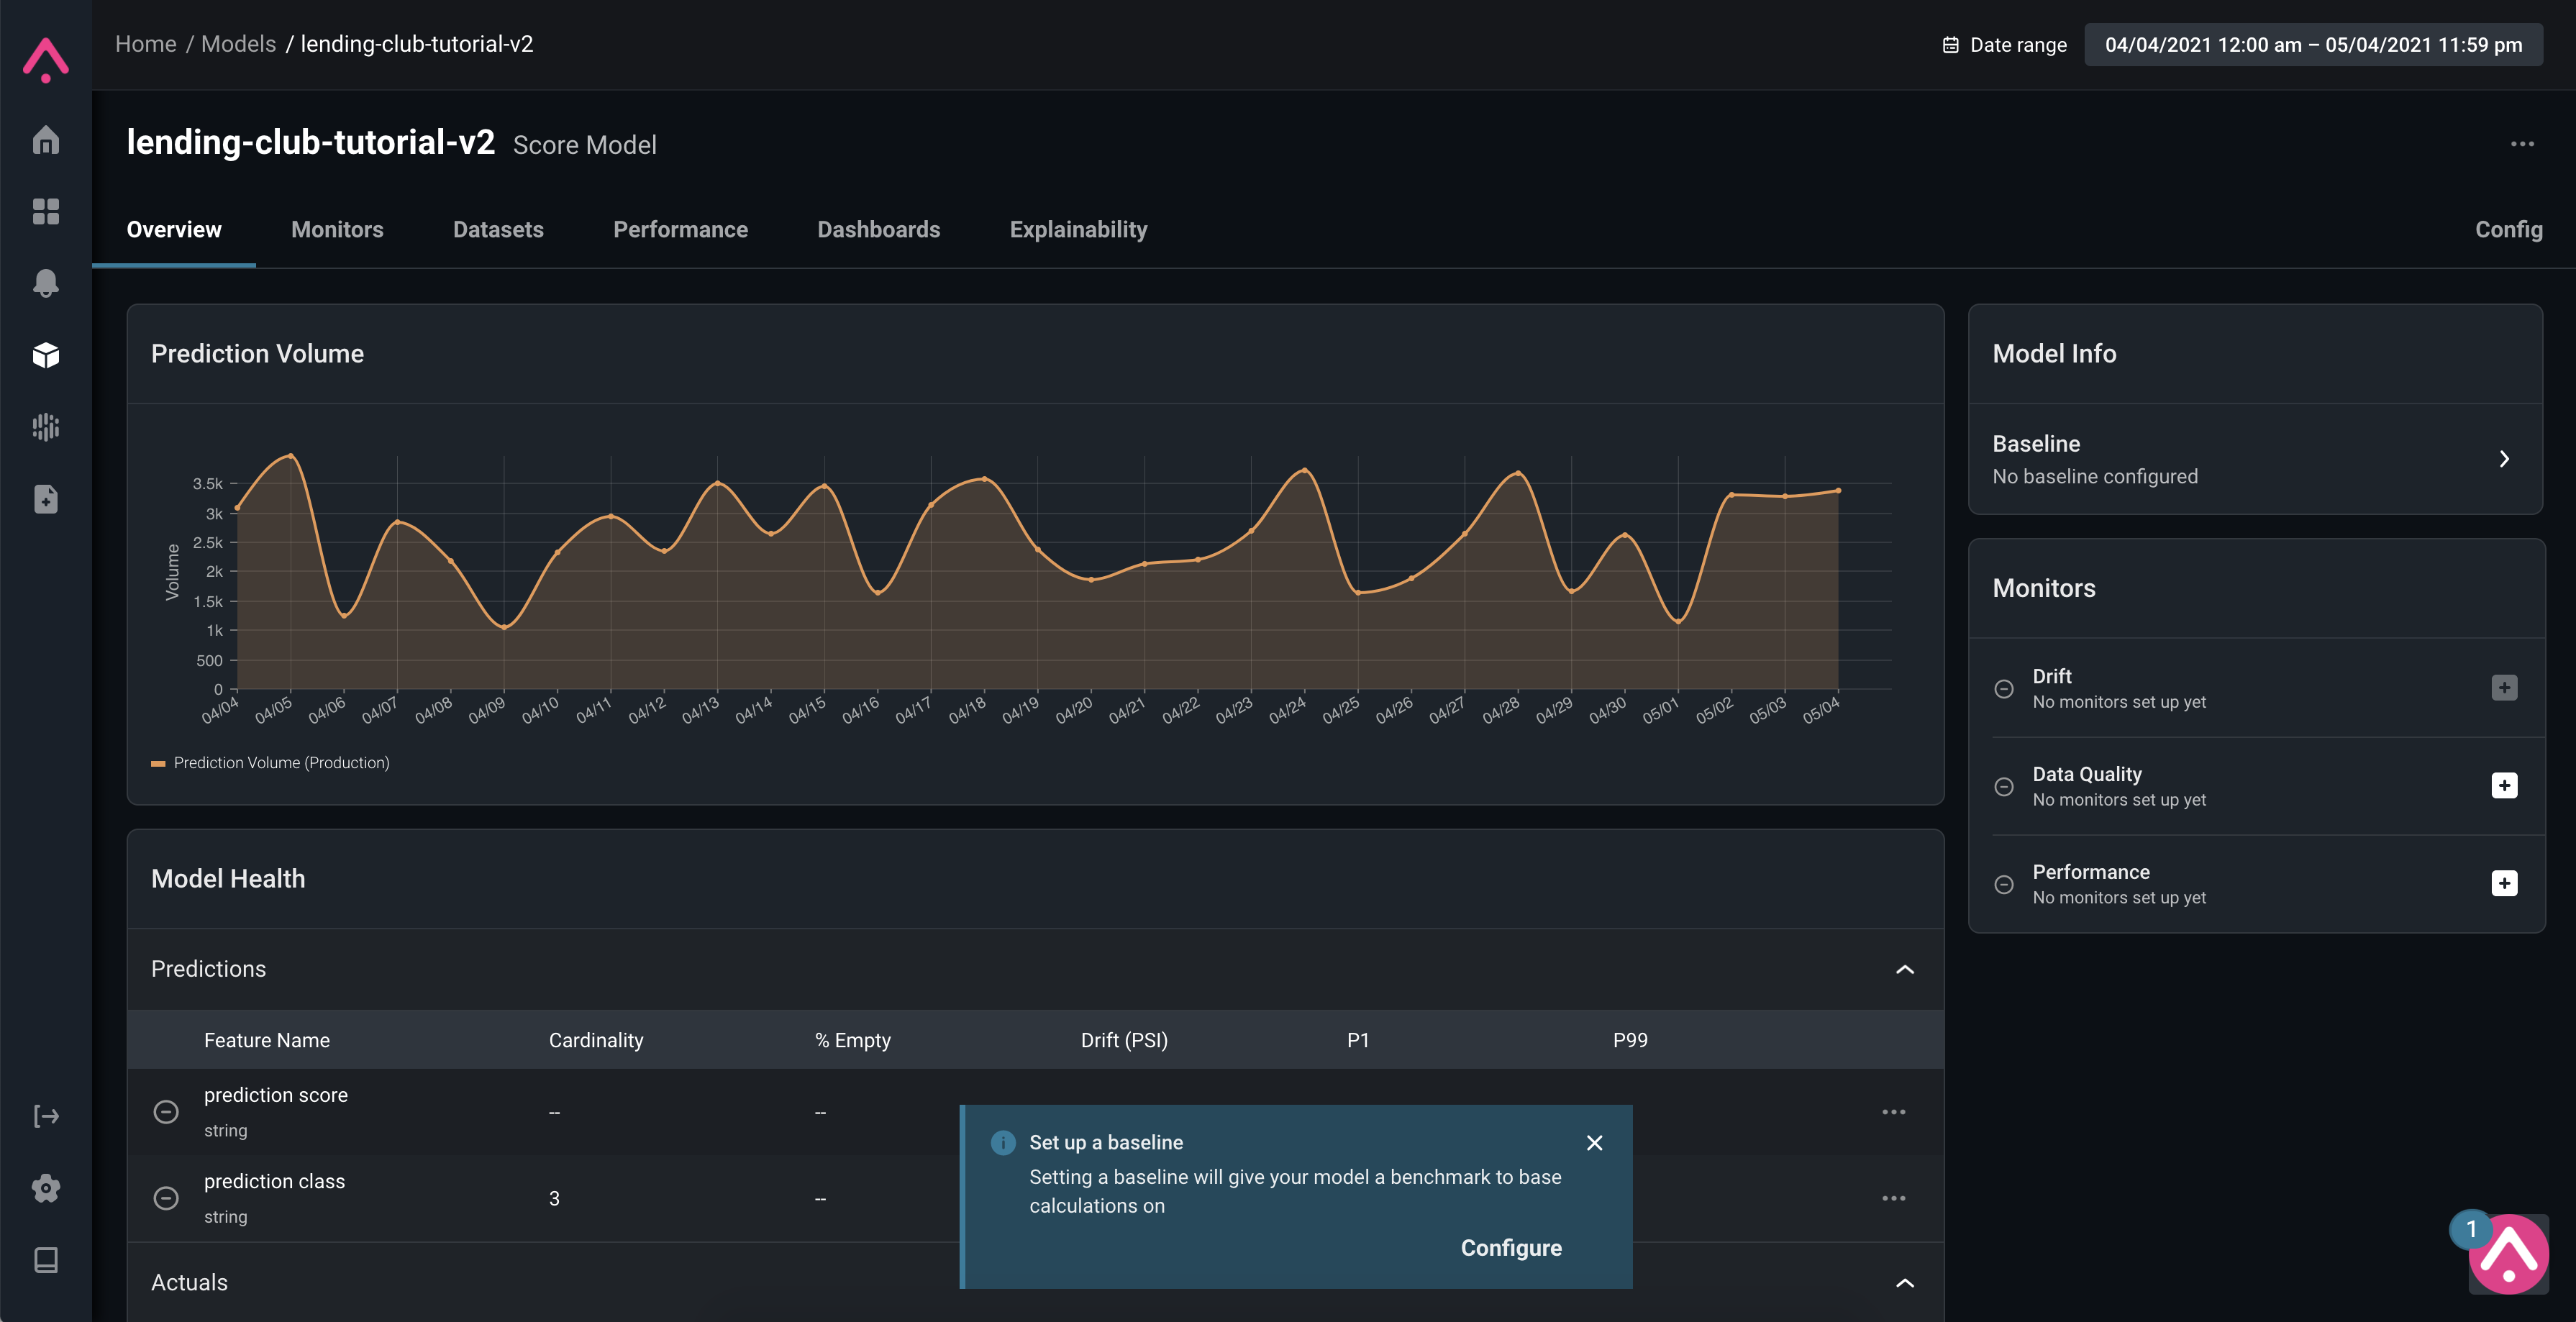

### Setting up a Baseline

One of the first steps for performance analysis is to set up a baseline to compare your model to. Go ahead and click on the **Configure** button in the bottom popup, or by going to the **Baseline** button on the right side of the screen. We're going to set our training data as our baseline. Click **Set as Baseline** under Actions on the training data row, and hit **Confirm** when the popup appears.

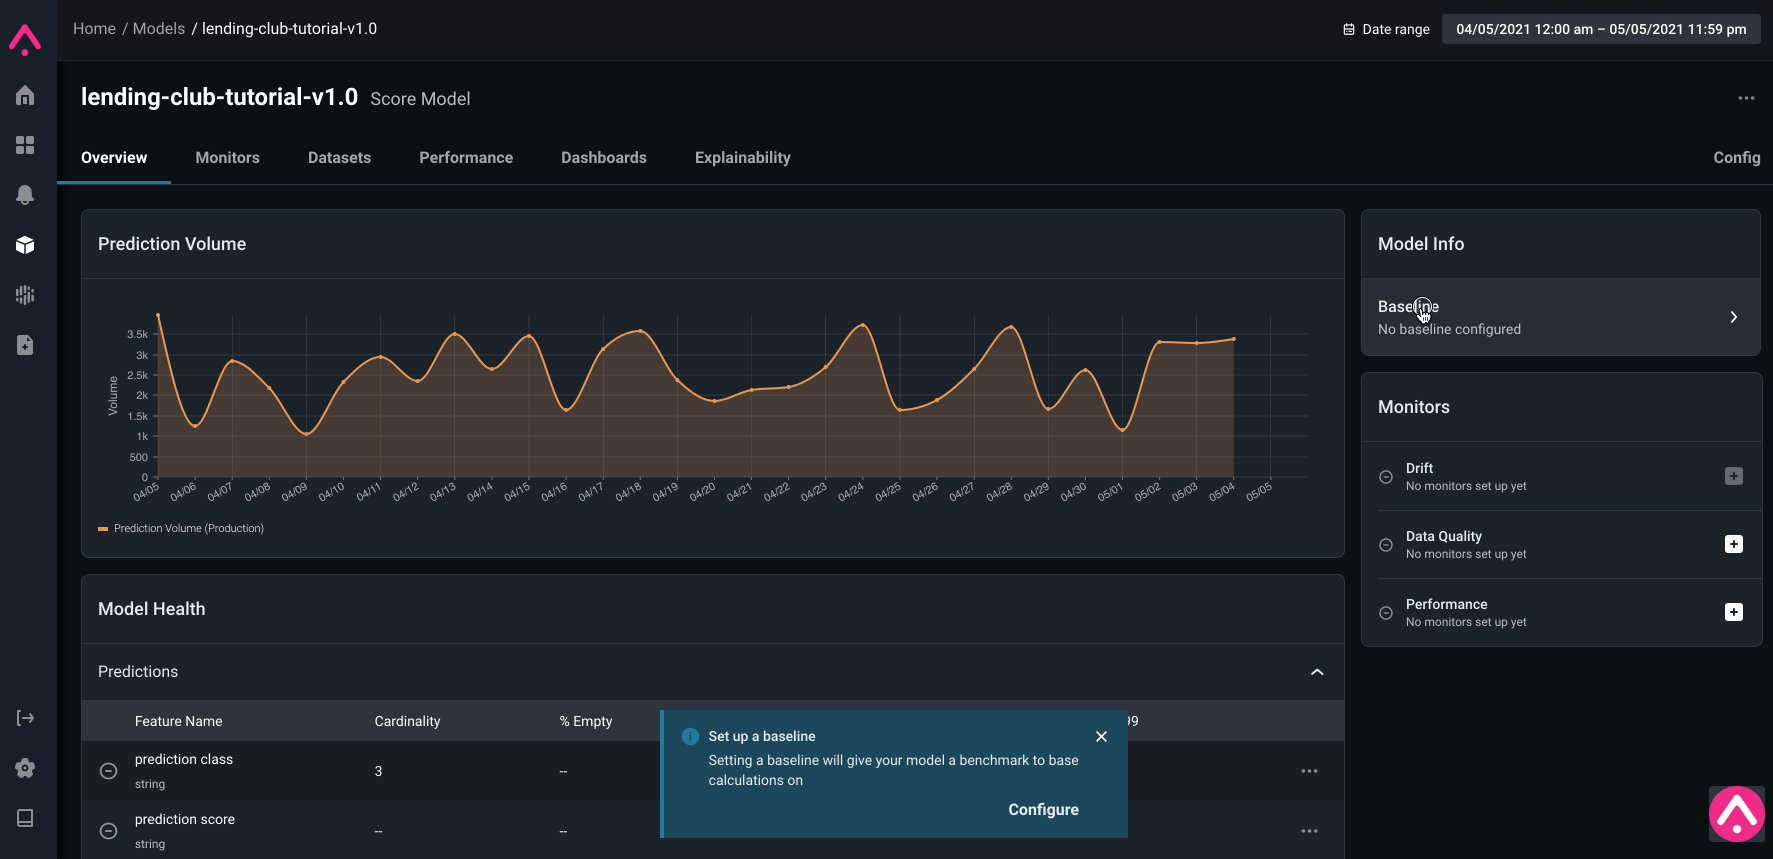

### Create a Performance Monitor
Now that we a baseline, let's go ahead and set up a Performance Monitor. This will allow us to track performance metrics and get alerted when the model is underperforming. Head over to the Performance tab on the right and hit the **+** to create a Performance Monitor.

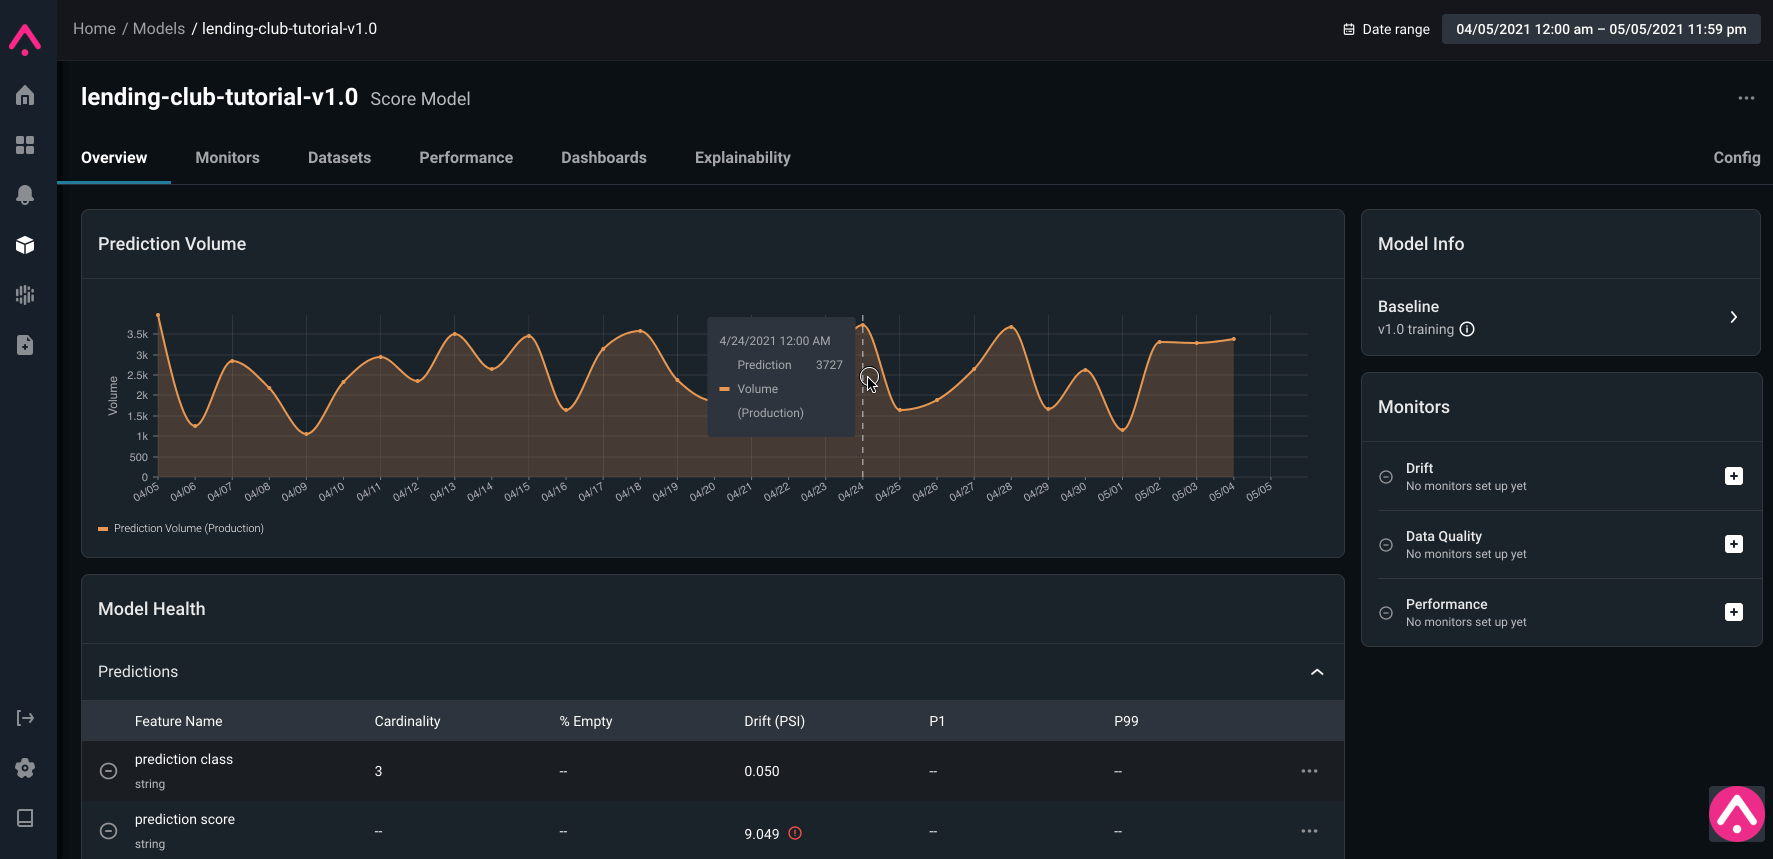

Fill out the performance monitor according the the following image (note your *Model* name might be slightly different). Arize offers a variety of metrics to monitor, and in this example we will be tracking the accuracy. When the accuracy dips below 0.65, the monitor will fire and you will know to investigate the performance issue.

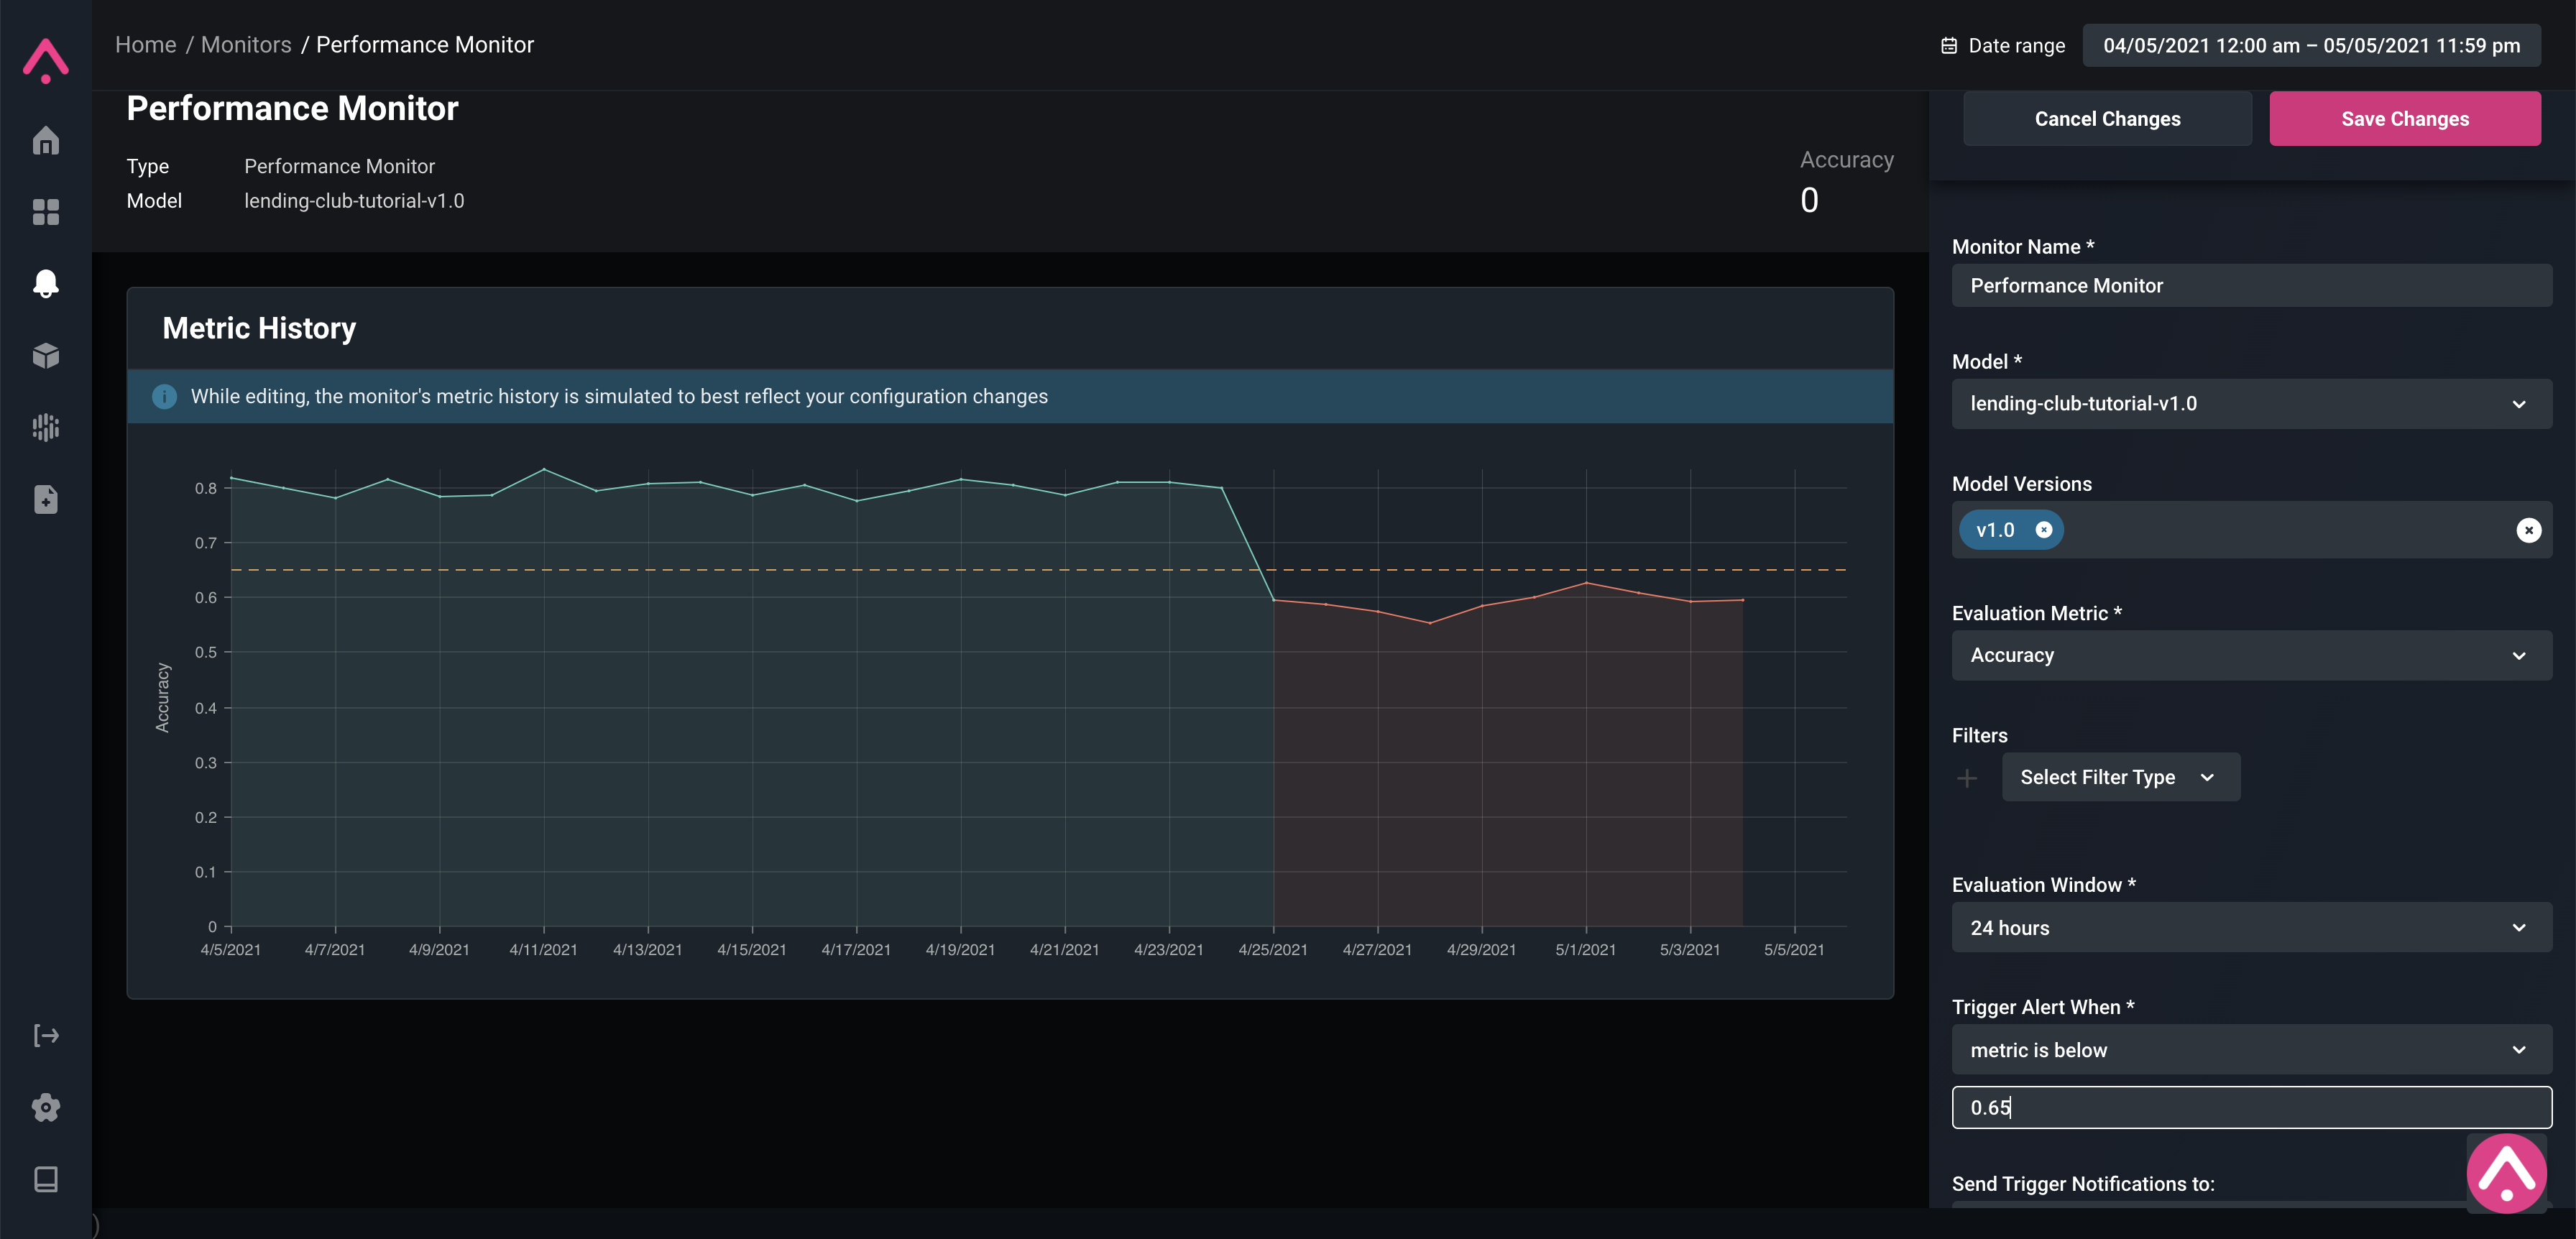

While we can see the accuracy chart while we fill out the widget, we also can find it easily by navigating to the **Monitors** page. With this monitor, it's clear to see where the performance starts to degrade. 

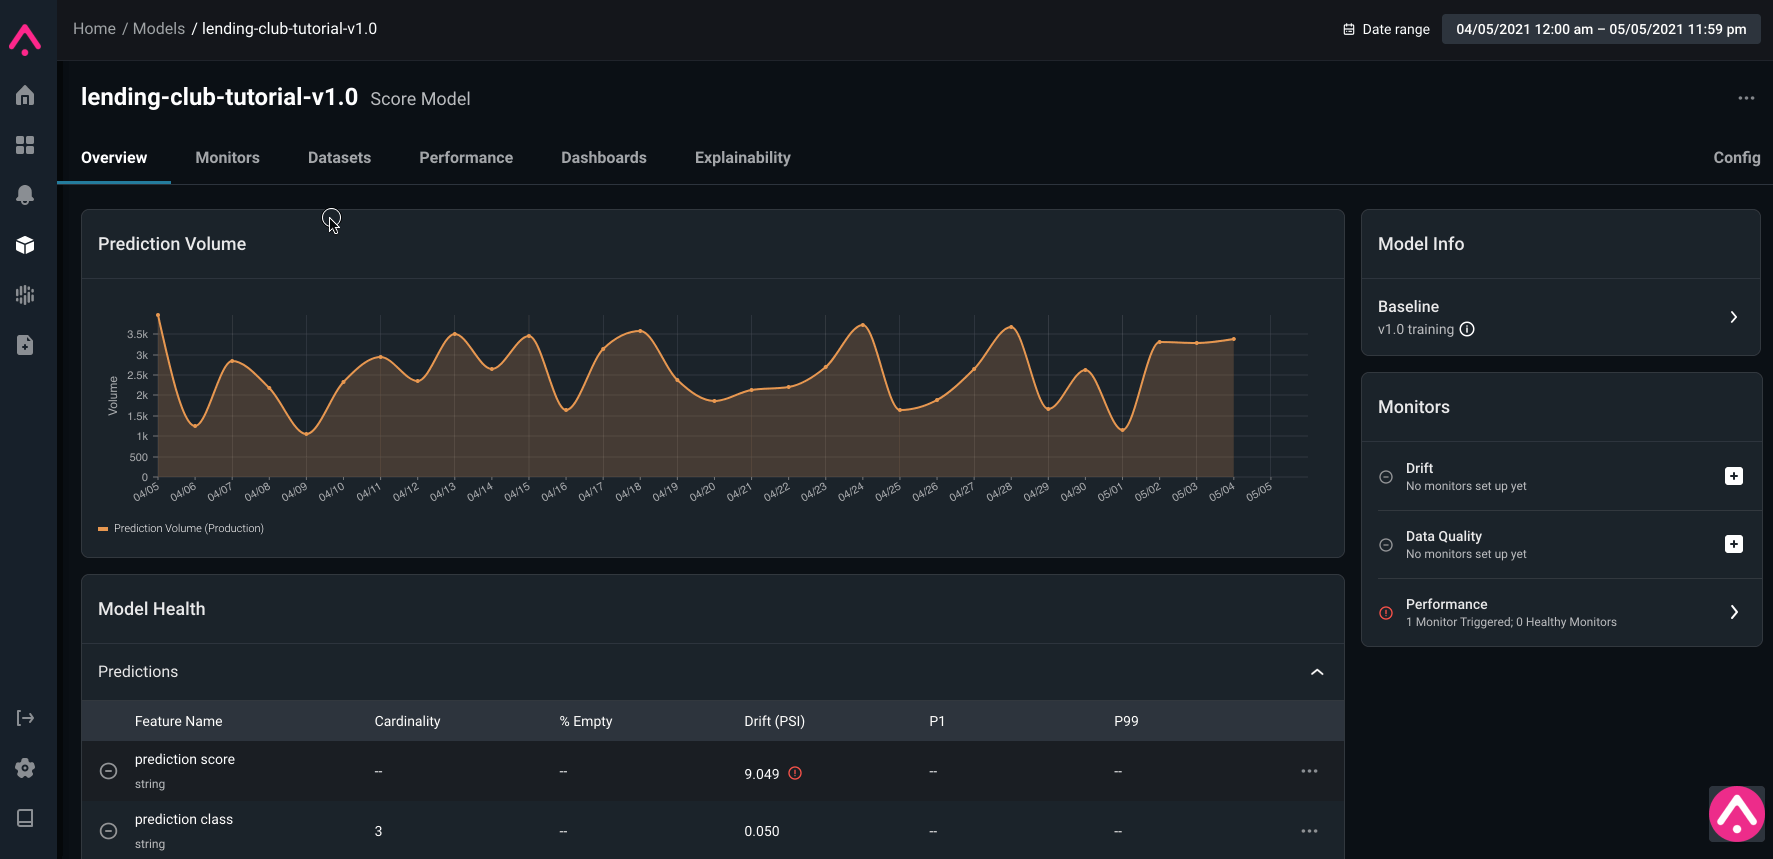

### Create a Feature Heatmap
Now that we've identified some performance degredation, let's do a deeper dive into where it's happening. Arize is great at slicing and dicing data by feature in order to pinpoint where metrics are dipping. One tool to do that is the Feature Performance Heatmap. Head over to the **Dashboards** page and hit **Create Dashboard**. From there follow the below guide to create the heatmap.

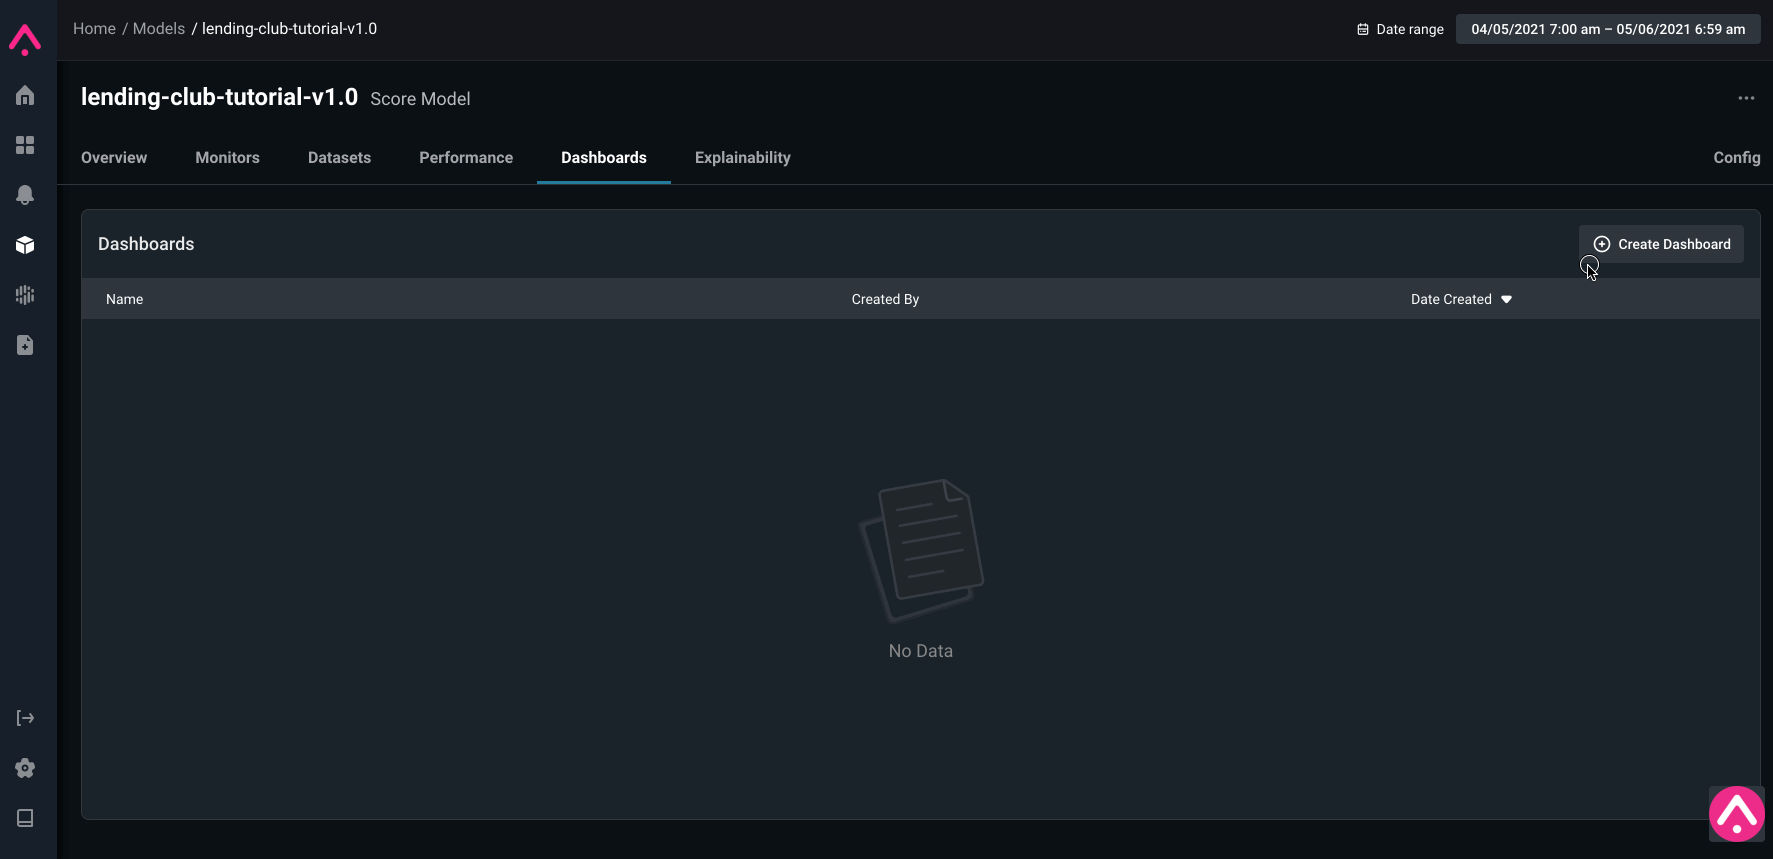

Fill out the heatmap fields as follows. We will create heatmaps for all the features based on accuracy to see if any have particularly high discrepancy in accuracy between values. This is illustrated through color, where red indicates a problematic statistic value, and yellow indicates a good statistic value. This could give us a clue into what's driving that performance dip. After you create the dashboard, feel free to explore around and look for potential sources.

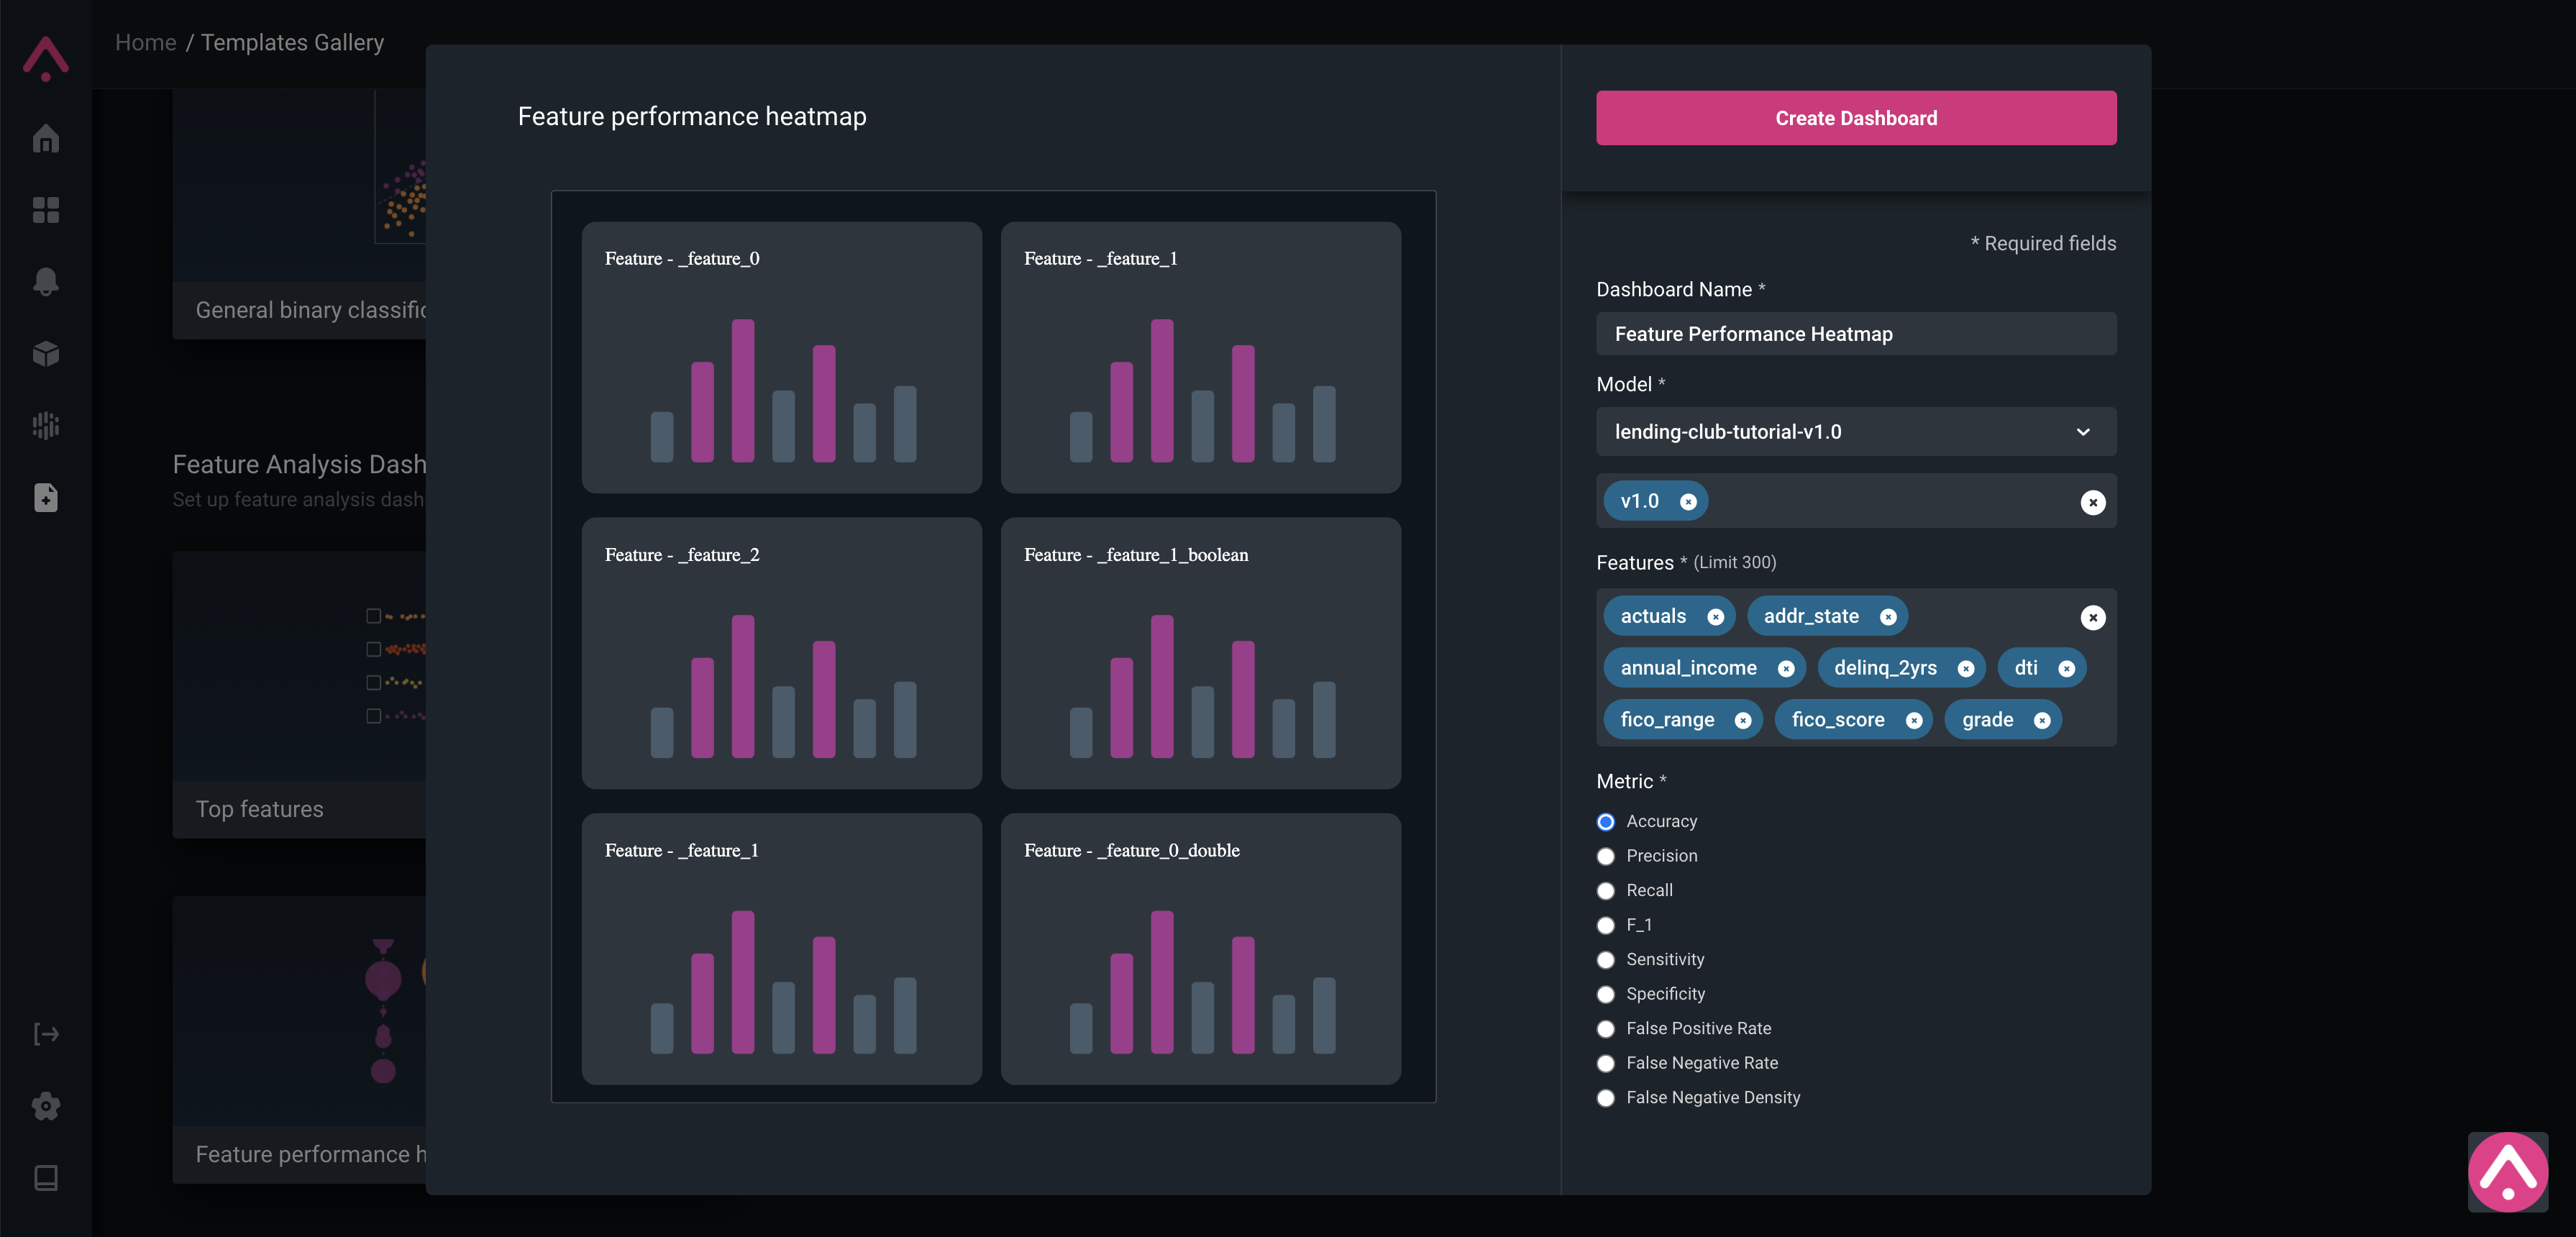

If you haven't already discovered it, scroll down to the **Feature - purpose** widget. A quick glance at it reveals a huge disparity between the accuracy for `pawn_shop_loan` and `debt_consolidation`. 

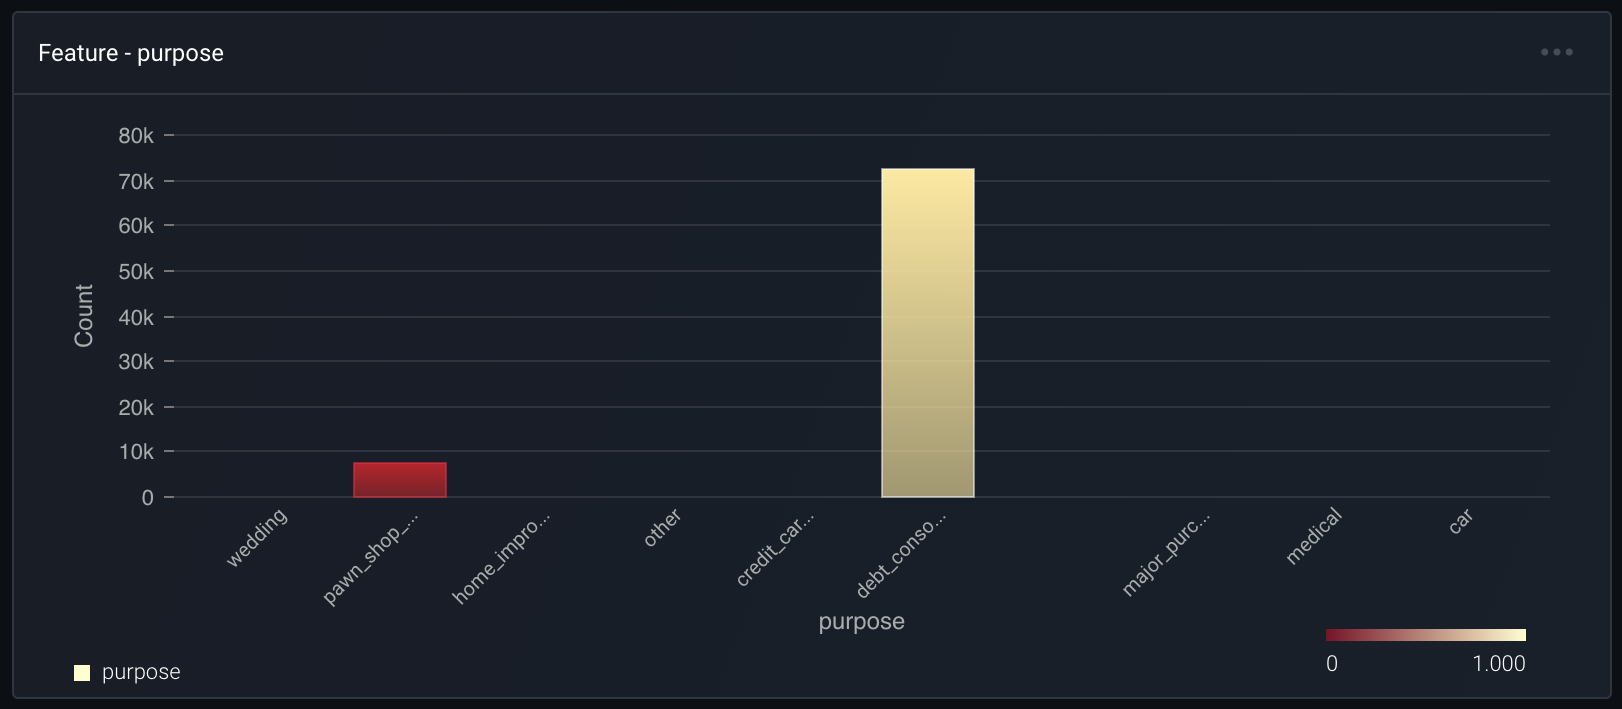

**Note:** another way to find this high-discrepancy feature would be to hit the *Show Performance Slices* button in the top right corner to see the worst performing feature slices.

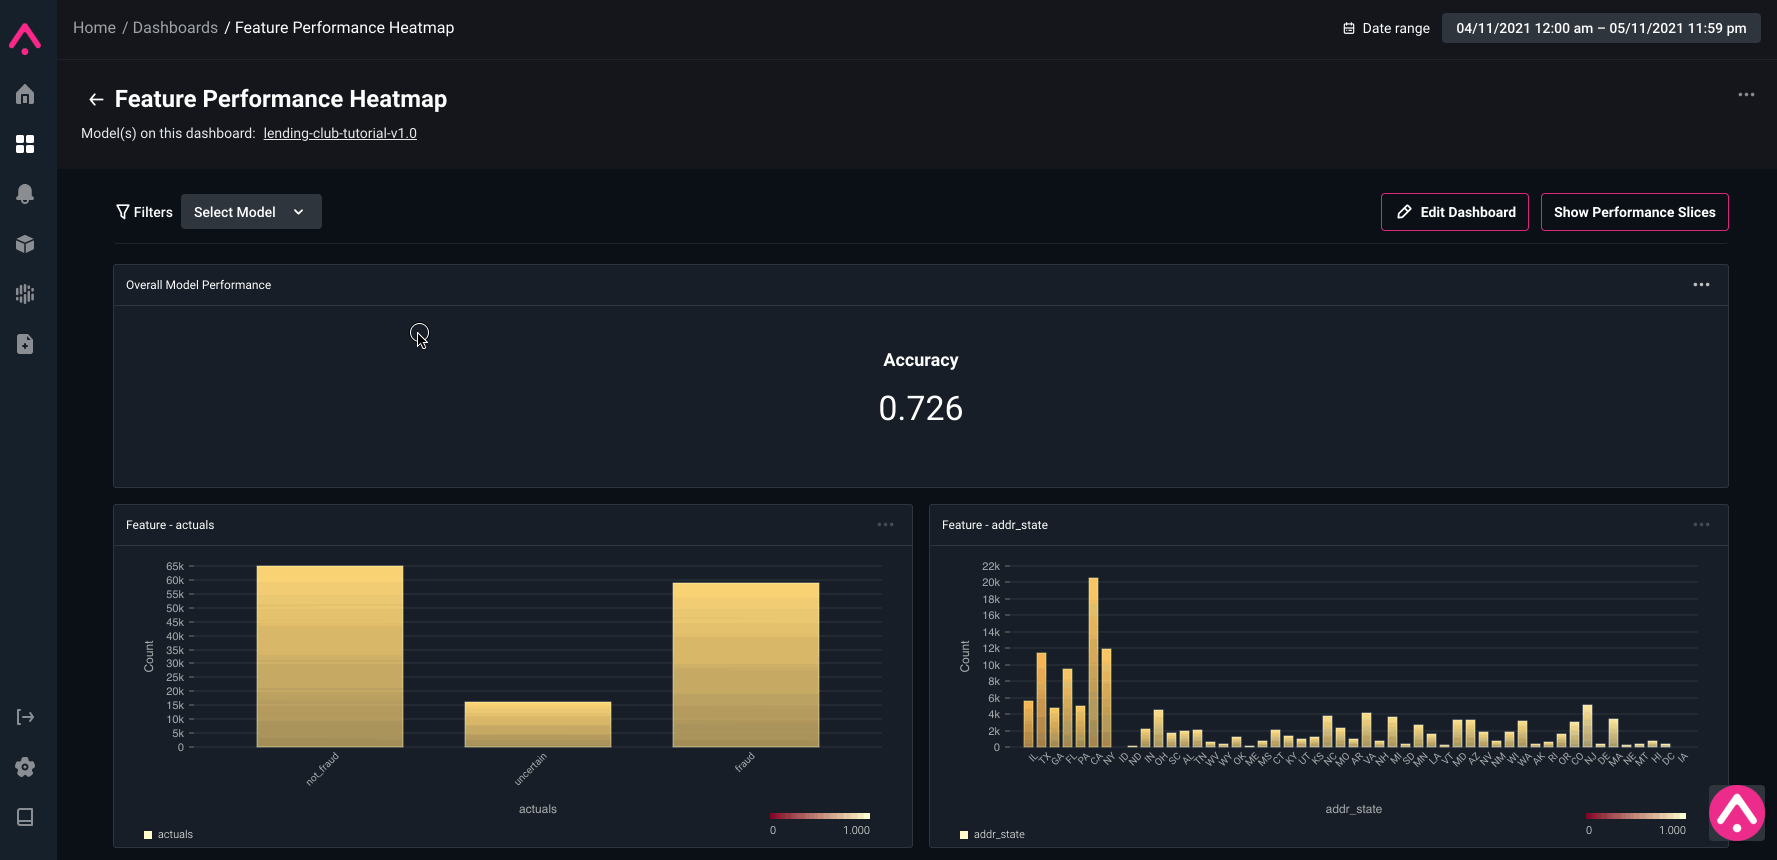


**Congratulations!** 🎉   We tracked down a potential source of the accuracy dip to a spike in pawn shop loans. Of course to be certain, we would have to do some further investigation. But it's safe to say this could definitely be a contributing factor. In order to prevent this from happening in the future, we will do one last thing, and that's create a drift monitor for the *purpose* feature to get alerted if it drifts again.

### Creating a Feature Drift Monitor

Head back to the **Model Overview** page. Arize allows easy creation of drift monitors for all features using the plus button next to **Drift** on the right side of the screen. Go ahead and press that to set up the drift monitors, which will include the one we are after, the *purpose* feature drift monitor.

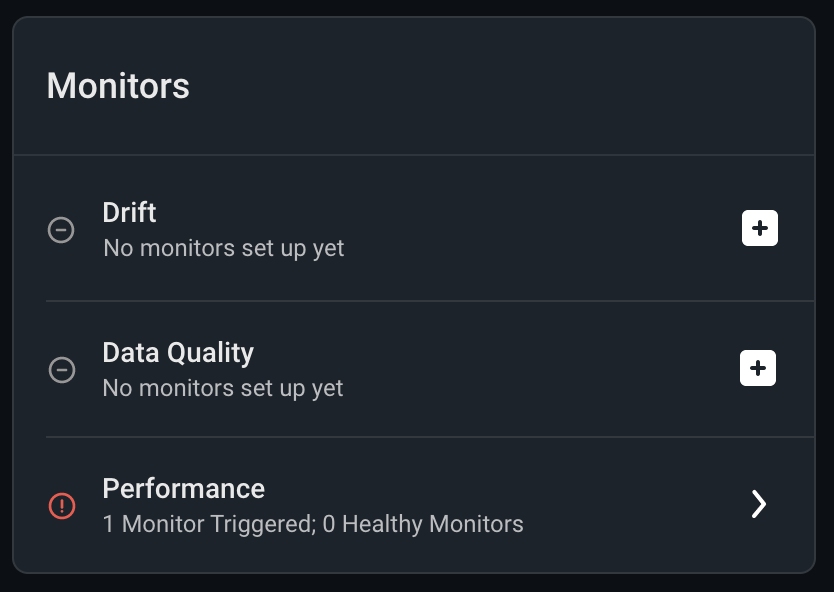

Now that the monitor is setup, let's go and check it out. Head over to the **Monitors** page and scroll down to our purpose monitor. Clicking on it takes you to a visualization of the feature timeseries, as well as a place to edit the monitor. We demonstrate how email alerts can be setup for when the monitor is triggered.

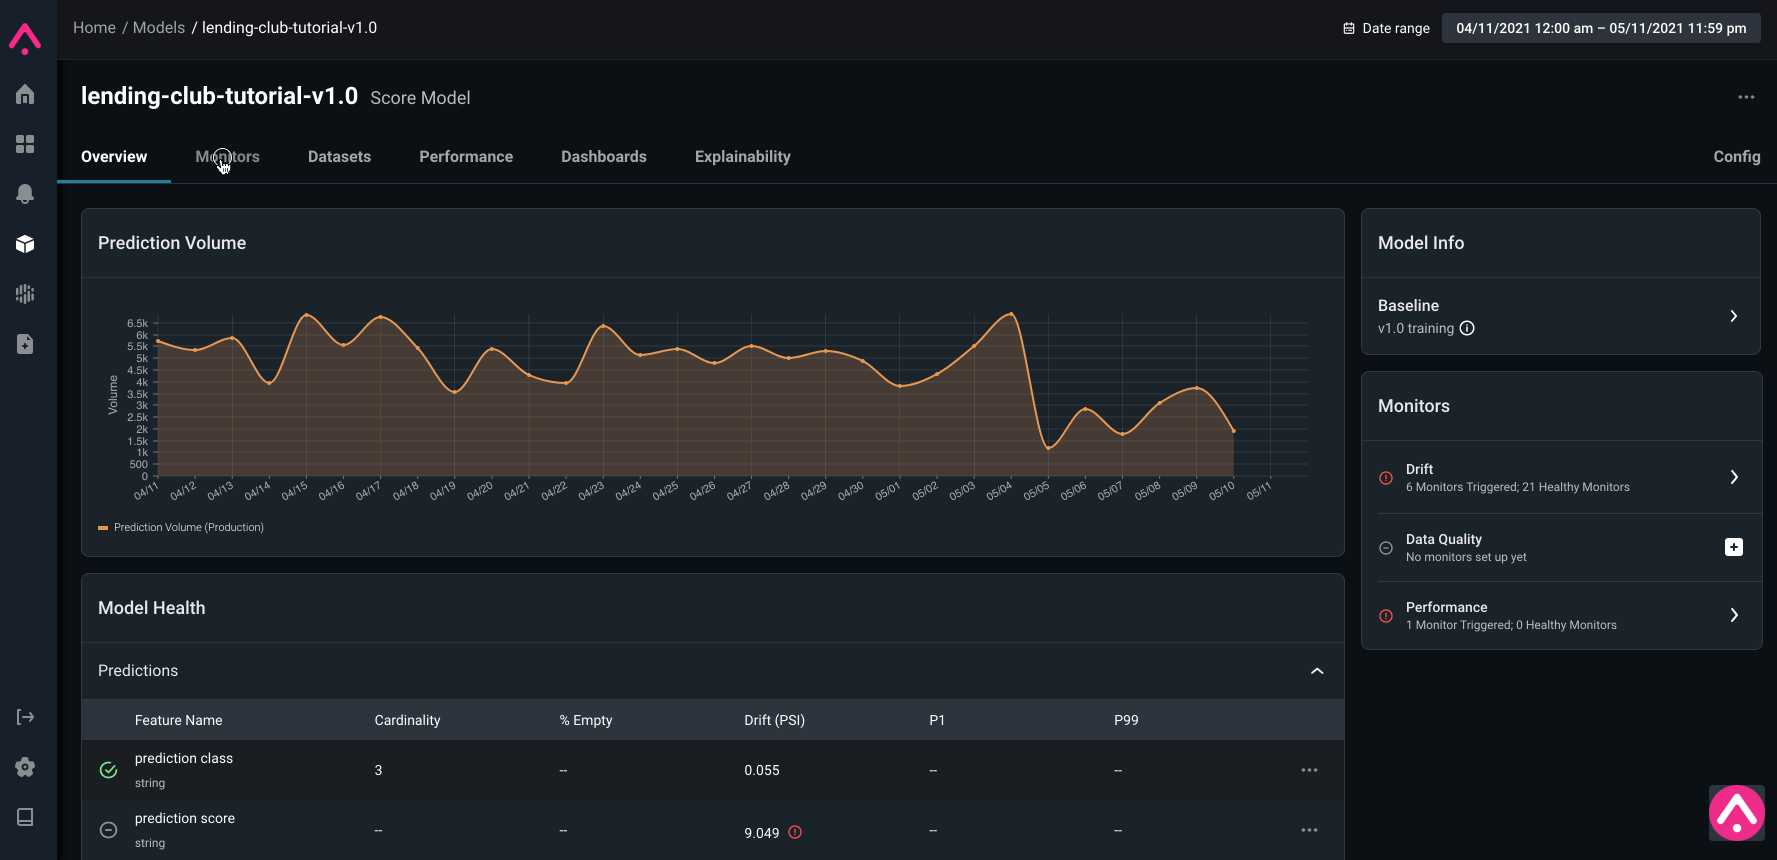

# Wrap Up 🎁

In this walkthrough we've shown how Arize can be used to log prediction data for a model, pinpoint a dip in model performance, and set up monitors to catch future issues. Though we covered a lot of ground, this is just scratching the surface of what the Arize platform can do. We urge you to explore more of Arize, either on your own or through one of our many other tutorials.